# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [338]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [339]:
df_offers = pd.read_excel("/users/hp/desktop/Ds-springboard/mini_project/customer_segmentation/clustering/WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

/Users/hp/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [340]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [341]:
#merge dataframes
df = df_offers.merge(df_transactions)
df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [342]:
# create a "pivot table" which will give us the number of times each customer responded to a given offer
matrix = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')
# a little tidying up. fill NA values with 0 and make the index into a column
matrix = matrix.fillna(0).reset_index()
# save a list of the 0/1 columns. we'll use these a bit later
x_cols = matrix.columns[1:]

matrix.tail()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
95,Williams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96,Wilson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
97,Wood,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
98,Wright,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99,Young,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [343]:
x_cols

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype='object', name='offer_id')

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

In [344]:
#Import KMeans
import numpy as np
from sklearn.cluster import KMeans

x_cols = matrix.drop(['customer_name'], axis=1)
ss=[]
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(x_cols)
    ss.append(kmeans.inertia_)

-- What challenges did you experience using the Elbow method to pick  𝐾 ?

Using this method it is very difficult to identify an elbow in the plot as the error appears to decay at a constant rate.

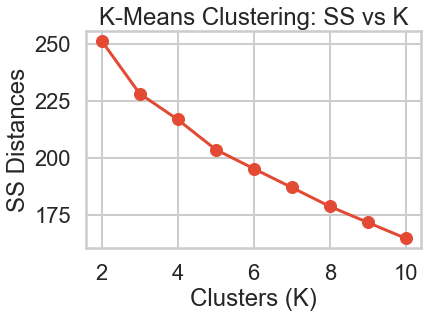

In [345]:
# Plot SS vs K.
#
plt.plot(range(2,11), ss,'-o')
plt.xlabel('Clusters (K)')
plt.ylabel('SS Distances')
plt.title('K-Means Clustering: SS vs K')
plt.show()

Above elbow plot illustrates the best choice of K=4 or K=8, would be a good choice for selection of number of clusters.

array([13, 16, 35, 36])

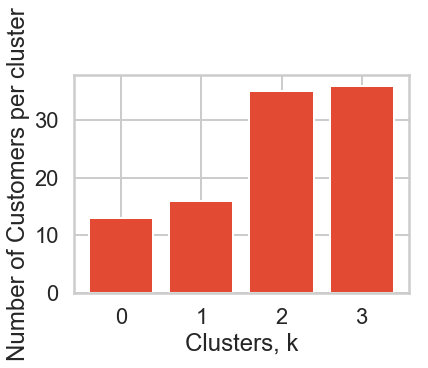

In [346]:
# Make a bar chart showing the number of points in each cluster for k-means under the best K.

kmeans = KMeans(n_clusters=4, random_state=0).fit(x_cols)
matrix['cluster'] = kmeans.predict(x_cols)
unique, counts = np.unique(kmeans.labels_, return_counts=True)
# bar chart
plt.bar(unique, counts, align = 'center')
plt.xlabel('Clusters, k')
plt.ylabel('Number of Customers per cluster')
counts

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.09365573283492713


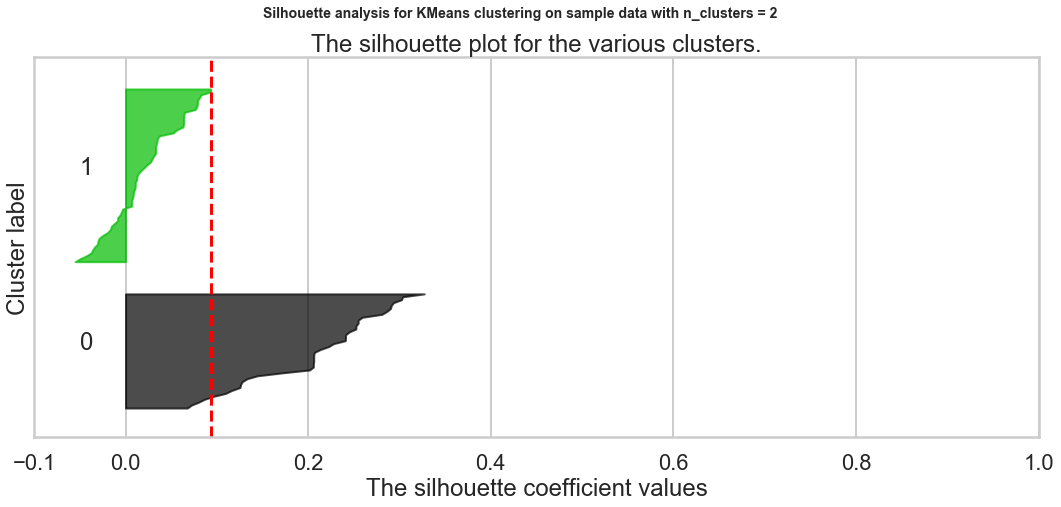

For n_clusters = 3 The average silhouette_score is : 0.11889942863638556


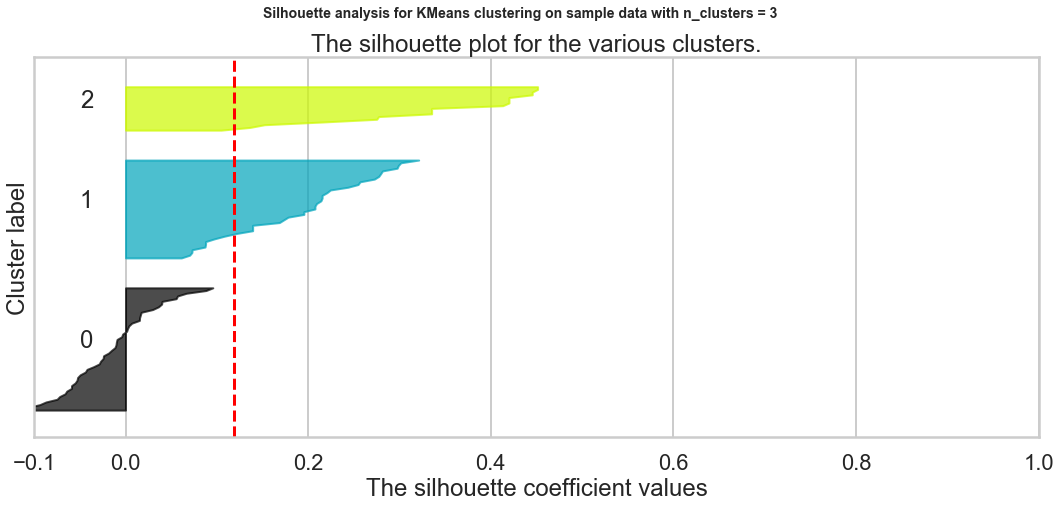

For n_clusters = 4 The average silhouette_score is : 0.12347053919571699


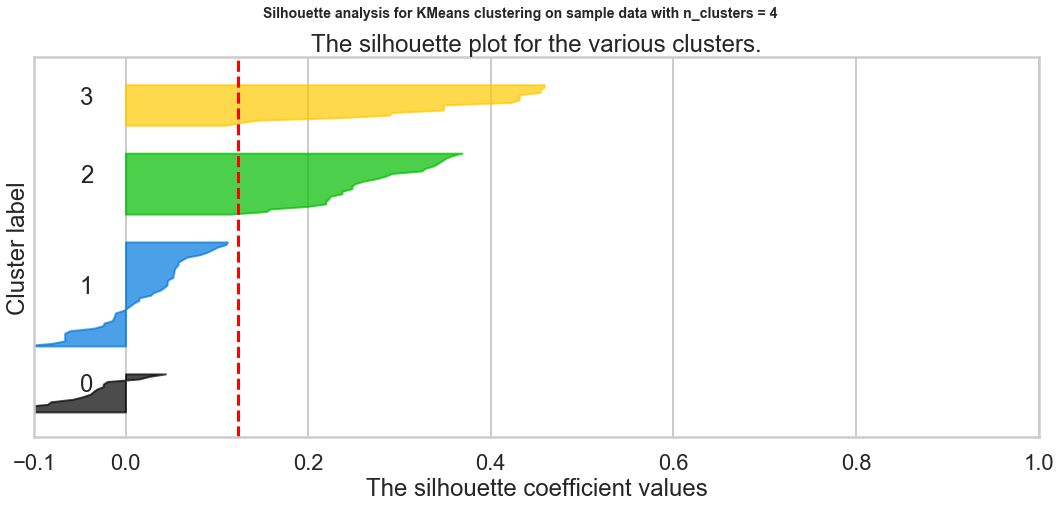

For n_clusters = 5 The average silhouette_score is : 0.14092516241984757


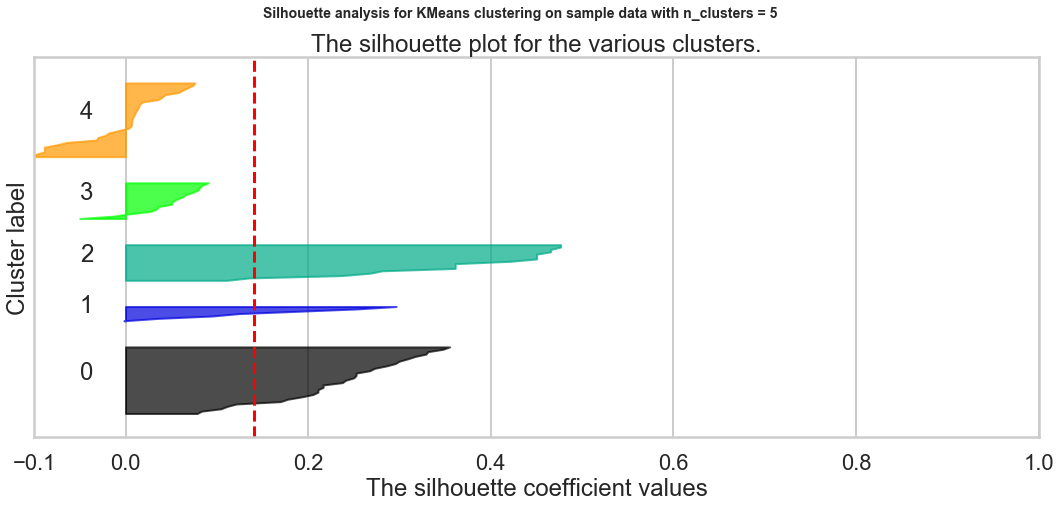

For n_clusters = 6 The average silhouette_score is : 0.1371798939109807


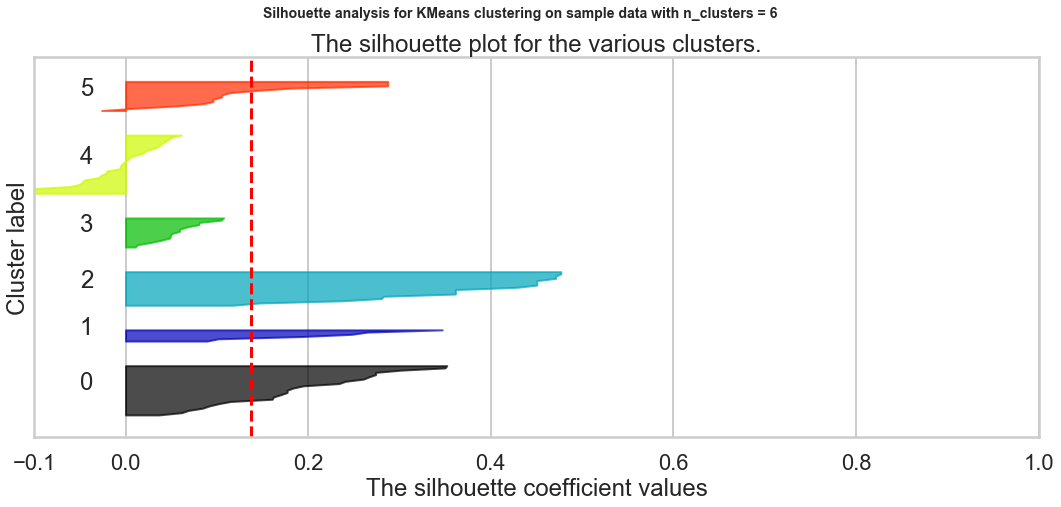

For n_clusters = 7 The average silhouette_score is : 0.1161092456616906


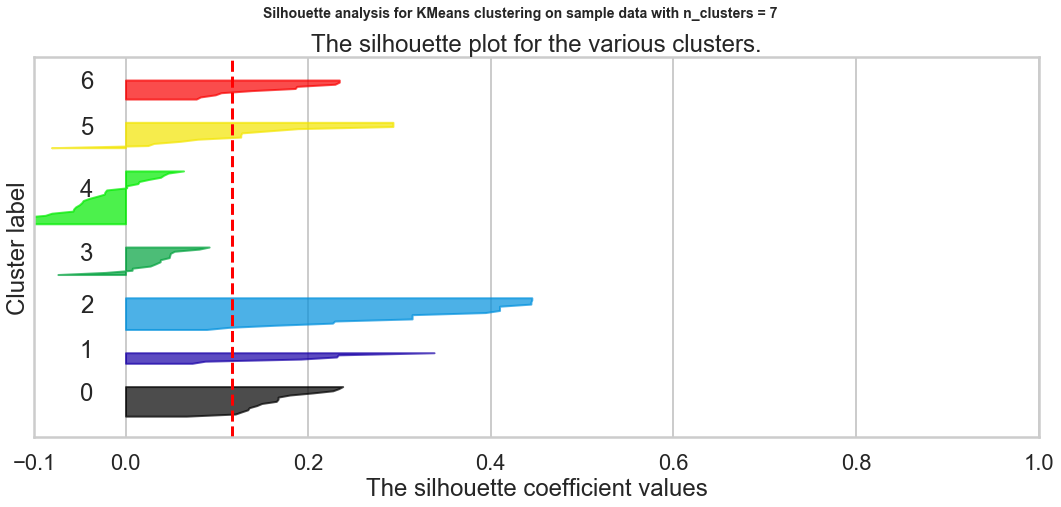

For n_clusters = 8 The average silhouette_score is : 0.11339573832632867


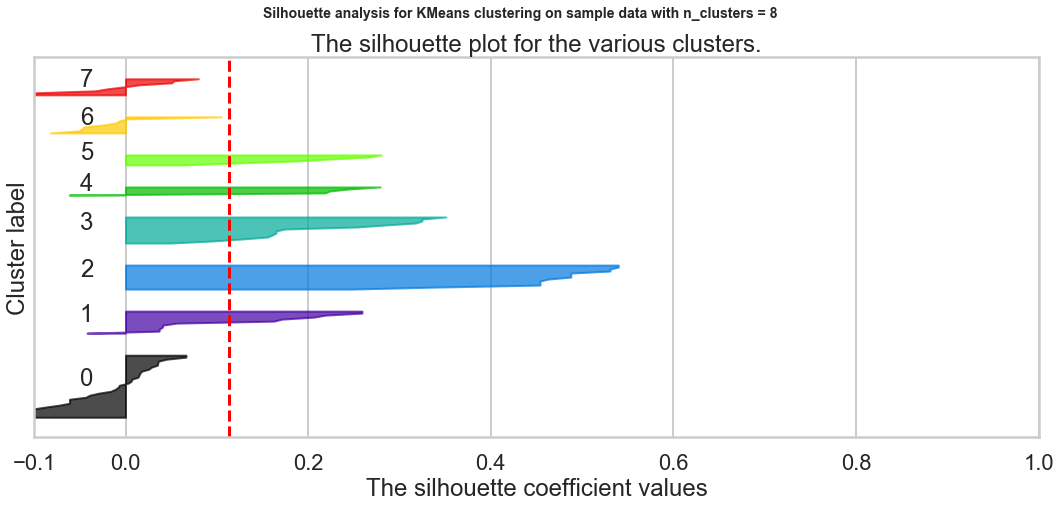

For n_clusters = 9 The average silhouette_score is : 0.12505960527779877


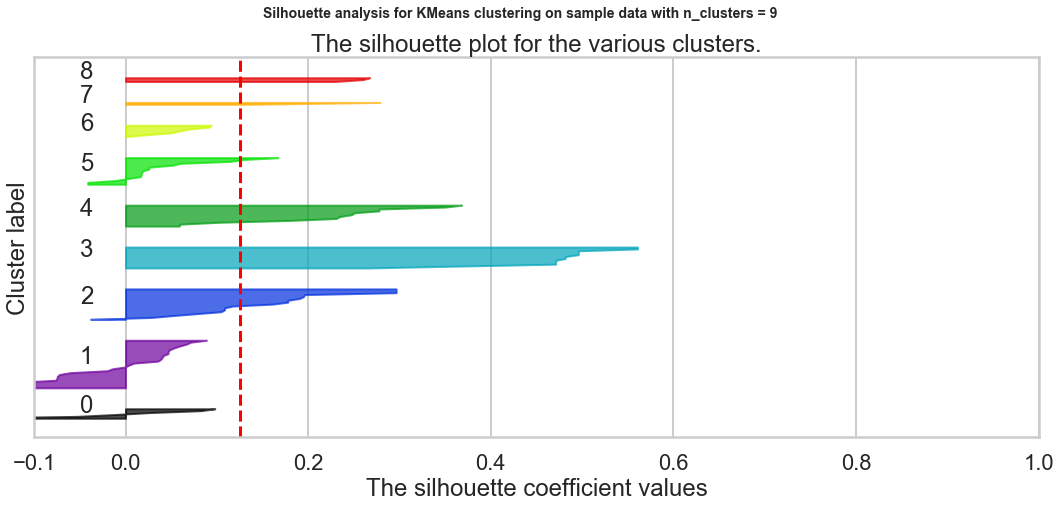

For n_clusters = 10 The average silhouette_score is : 0.11928332134753233


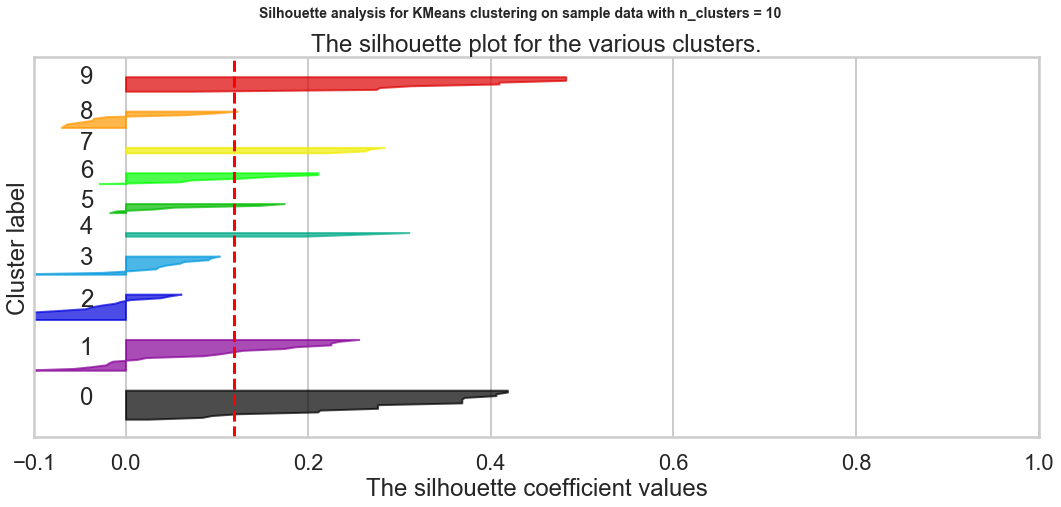

In [347]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = x_cols
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10 ]
sil_score = {}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sil_score[n_clusters]=silhouette_avg

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
   

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()


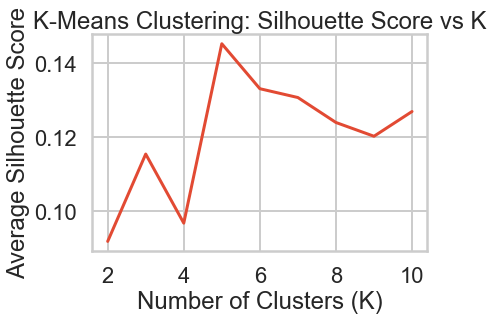

In [348]:
#Silhoutte score plot
plt.plot(range(2,11), silhouette)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.title('K-Means Clustering: Silhouette Score vs K')
plt.show()

Based on above plot, K=5 has highest silhoutte score.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [349]:
#your turn
from sklearn.decomposition import PCA

# Apply PCA to reduce 32 dimensions into only 2 components

pca = PCA(n_components=2, random_state=42)

# Create a dataframe.

customers_df = pd.DataFrame(matrix[['customer_name', 'cluster']])
customers_df['x'] = pca.fit_transform(x_cols)[:,0]
customers_df['y'] = pca.fit_transform(x_cols)[:,1]
customers_df

offer_id,customer_name,cluster,x,y
0,Adams,2,1.007580,0.108215
1,Allen,3,-0.287539,0.044715
2,Anderson,1,-0.392032,1.038391
3,Bailey,2,0.699477,-0.022542
4,Baker,3,0.088183,-0.471695
5,Barnes,3,-0.485282,-0.725503
6,Bell,1,-0.591941,1.506500
7,Bennett,2,0.661732,0.090308
8,Brooks,3,-0.118943,-0.577499
9,Brown,2,1.079827,-0.007488


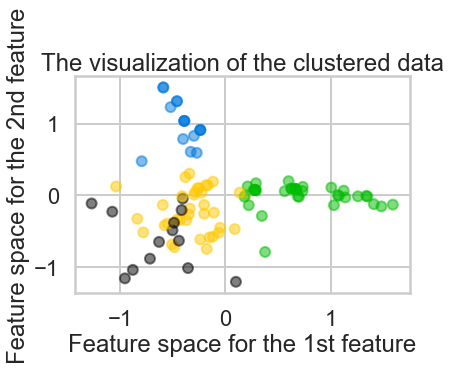

In [350]:
# Create a scatter plot of the two principal components 
colors = cm.nipy_spectral(customers_df.cluster.astype(float) / 4)
plt.scatter(customers_df.x, customers_df.y, marker='o', s=100, alpha=0.5, c=colors)
plt.title("The visualization of the clustered data")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

Visualizing the data in two-dimensional space reveals that the two clusters, black and yellow have some overlapping and are generally weak in both principal components. The green cluster is distinctively higher in the first principal component than other clusters, and the blue cluster is clearly stronger in the second principal component. Based on the this graph, three clusters might be sufficient.

In [351]:
# Group transactions data by clusters to see the frequency of purchase for each offer
df_clusters = matrix.groupby('cluster').mean()
df_clusters = df_clusters.stack().unstack('cluster').reset_index()
df_clusters 

cluster,offer_id,0,1,2,3
0,1,0.076923,0.0625,0.000000,0.222222
1,2,0.000000,0.3750,0.000000,0.111111
2,3,0.153846,0.0000,0.057143,0.055556
3,4,0.538462,0.0000,0.000000,0.138889
4,5,0.153846,0.0000,0.000000,0.055556
5,6,0.846154,0.0000,0.028571,0.000000
6,7,0.153846,0.0000,0.457143,0.027778
7,8,0.076923,0.0000,0.485714,0.055556
8,9,0.153846,0.0000,0.000000,0.222222
9,10,0.076923,0.0625,0.057143,0.083333


In [352]:
# Merge clustered data with offer details and show cluster's tendency to purchase each offer
df = pd.merge(df_clusters, df_offers, how='left', on='offer_id')
df

,offer_id,0,1,2,3,campaign,varietal,min_qty,discount,origin,past_peak
0,1,0.076923,0.0625,0.000000,0.222222,January,Malbec,72,56,France,False
1,2,0.000000,0.3750,0.000000,0.111111,January,Pinot Noir,72,17,France,False
2,3,0.153846,0.0000,0.057143,0.055556,February,Espumante,144,32,Oregon,True
3,4,0.538462,0.0000,0.000000,0.138889,February,Champagne,72,48,France,True
4,5,0.153846,0.0000,0.000000,0.055556,February,Cabernet Sauvignon,144,44,New Zealand,True
5,6,0.846154,0.0000,0.028571,0.000000,March,Prosecco,144,86,Chile,False
6,7,0.153846,0.0000,0.457143,0.027778,March,Prosecco,6,40,Australia,True
7,8,0.076923,0.0000,0.485714,0.055556,March,Espumante,6,45,South Africa,False
8,9,0.153846,0.0000,0.000000,0.222222,April,Chardonnay,144,57,Chile,False
9,10,0.076923,0.0625,0.057143,0.083333,April,Prosecco,72,52,California,False


In [353]:
df[df[0] >= 0.25]

,offer_id,0,1,2,3,campaign,varietal,min_qty,discount,origin,past_peak
3,4,0.538462,0.0000,0.000000,0.138889,February,Champagne,72,48,France,True
5,6,0.846154,0.0000,0.028571,0.000000,March,Prosecco,144,86,Chile,False
19,20,0.307692,0.0000,0.000000,0.055556,August,Cabernet Sauvignon,72,82,Italy,False
21,22,0.538462,0.0000,0.028571,0.361111,August,Champagne,72,63,France,False
26,27,0.307692,0.0625,0.028571,0.083333,October,Champagne,72,88,New Zealand,False
30,31,0.384615,0.0000,0.000000,0.333333,December,Champagne,72,89,France,False


In [354]:
df[df[1] >= 0.25]

,offer_id,0,1,2,3,campaign,varietal,min_qty,discount,origin,past_peak
1,2,0.000000,0.3750,0.0,0.111111,January,Pinot Noir,72,17,France,False
16,17,0.000000,0.4375,0.0,0.000000,July,Pinot Noir,12,47,Germany,False
23,24,0.000000,0.7500,0.0,0.000000,September,Pinot Noir,6,34,Italy,False
25,26,0.153846,0.7500,0.0,0.027778,October,Pinot Noir,144,83,Australia,False


In [355]:
df[df[2] >= 0.25]

,offer_id,0,1,2,3,campaign,varietal,min_qty,discount,origin,past_peak
6,7,0.153846,0.0,0.457143,0.027778,March,Prosecco,6,40,Australia,True
7,8,0.076923,0.0,0.485714,0.055556,March,Espumante,6,45,South Africa,False
17,18,0.000000,0.0,0.371429,0.027778,July,Espumante,6,50,Oregon,False
28,29,0.000000,0.0,0.457143,0.027778,November,Pinot Grigio,6,87,France,False
29,30,0.000000,0.0,0.457143,0.166667,December,Malbec,6,54,France,False


In [356]:
df[df[3] >= 0.25]

,offer_id,0,1,2,3,campaign,varietal,min_qty,discount,origin,past_peak
10,11,0.076923,0.0,0.000000,0.333333,May,Champagne,72,85,France,False
21,22,0.538462,0.0,0.028571,0.361111,August,Champagne,72,63,France,False
30,31,0.384615,0.0,0.000000,0.333333,December,Champagne,72,89,France,False


Above analyses indicate cluster 0 and 3 mostly likes champagne. Cluster 3 buy from only France varieties. Cluster 1 likes pinot noir regardless of orgin. Cluster 2 likes all variety regardless of orgin or type.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

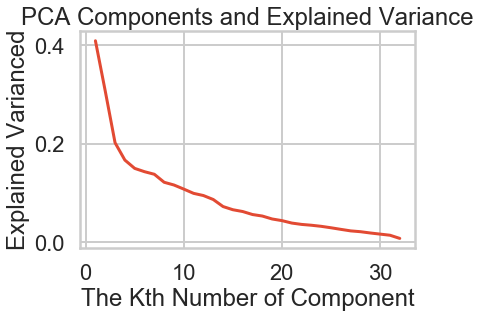

In [357]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(X)

# Do the rest on your own :)
# Plot the explained variance by each component
plt.plot(range(1,33), pca.explained_variance_)
plt.xlabel('The Kth Number of Component')
plt.ylabel('Explained Varianced')
plt.title('PCA Components and Explained Variance')
plt.show()

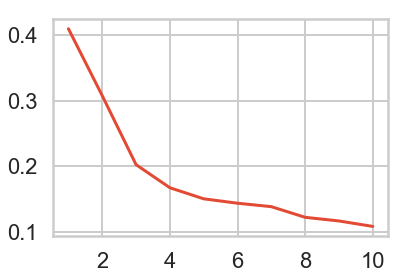

In [358]:
import numpy as np

plt.plot(np.arange(1,11,1),pca.explained_variance_[0:10])

This plot shows that the amount of variance explained by a component falls for each successive component and the rate of descent slows sharply after the third or fourth component. Thus, setting the number of components to be three or four seems to be a good choice.

From above variance method plot, K=4 seems to be the elbow point where the curve's rate of descent seems to slow sharply.



## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [359]:
# Your turn
from sklearn.cluster import  AgglomerativeClustering
from sklearn.cluster import  AffinityPropagation
from sklearn.cluster import  SpectralClustering

 Affinity Progagation
 
 Affinity Propagation has a preference parameter that controls how many examplars are used and updates based on the smiliarity between any two points until convergence, at which point the final examplars are chosen and thus the final clusters are formed. The algorithm is complex and computationally expensive, so it's most appropriate for small to medium sized datasets.

For our dataset, I set the input preference to be the minimal negative squared distance between any two points (which is -15). Affinity Propagation finds 5 clusters with cluster sizes ranging from 15 to 24. The scatter plot based on the previous two principal components shows that a good number of data points overlap, suggesting a poor clustering result.

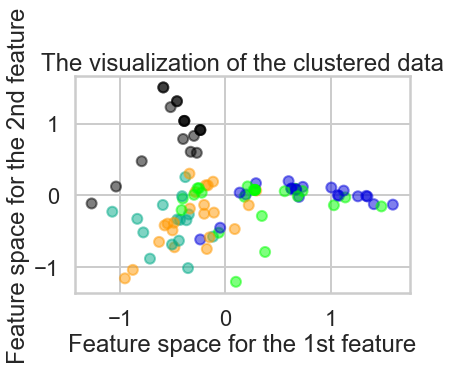

In [360]:
metrics_dict = {}

ap = AffinityPropagation(preference=-15)
aff_labels=ap.fit_predict(X)

# Create a scatter plot of the two principal components 
colors = cm.nipy_spectral(aff_labels.astype(float) / 5)
plt.scatter(customers_df.x, customers_df.y, marker='o', s=100, alpha=0.5, c=colors)
plt.title("The visualization of the clustered data")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()



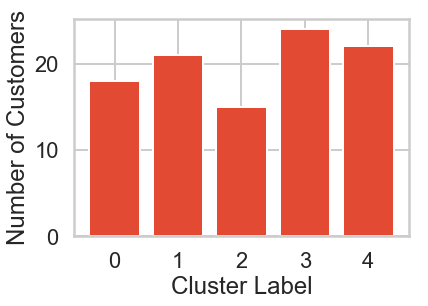

In [361]:
plt.hist(aff_labels, bins=5,  align='left', range=(0,5), rwidth=0.8)
plt.xticks(range(0,5))
plt.xlabel('Cluster Label')
plt.ylabel('Number of Customers')
plt.show()

Spectral clustering 
It requires the number of clusters to be specified and works well for small number of clusters. With four clusters, the visualized Spectral Clustering plot shows three distinct clusters and one smaller cluster overlapping with two other clusters.

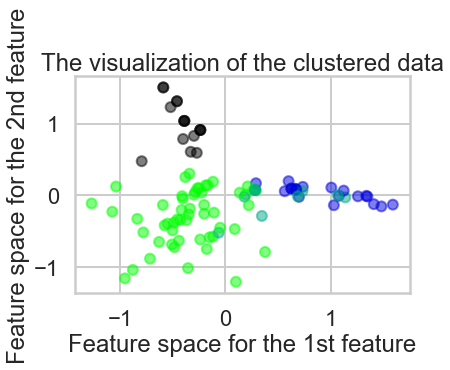

In [362]:
sc = SpectralClustering(n_clusters=4, assign_labels='discretize', random_state=0)
sc_labels = sc.fit_predict(X)

# Create a scatter plot of the two principal components 
colors = cm.nipy_spectral(sc_labels.astype(float) / 5)
plt.scatter(customers_df.x, customers_df.y, marker='o', s=100, alpha=0.5, c=colors)
plt.title("The visualization of the clustered data")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()



Agglomerative clustering

It performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together.

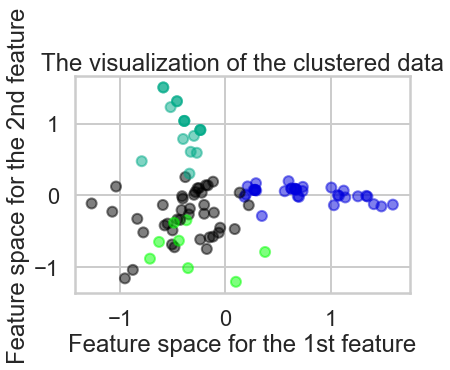

In [363]:
ac = AgglomerativeClustering(n_clusters=4, linkage='ward')
ac_labels = ac.fit_predict(X)

# Create a scatter plot of the two principal components 
colors = cm.nipy_spectral(ac_labels.astype(float) / 5)
plt.scatter(customers_df.x, customers_df.y, marker='o', s=100, alpha=0.5, c=colors)
plt.title("The visualization of the clustered data")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()


DBSCAN
DBSCAN is Density-Based Spatial Clustering with Applications with Noise. It finds core points of high density and expands clusters from them. It's good for data which contain clusters of similar density. Clusters found by DBSCAN can be of any shape, as opposed to k-means which assumes that clusters are convex-shaped. A core point is defined as a data point such that there exist min_samples within a distance of eps, which are defined as border points or neighbors of the core point. All other points are considered as noise points. Higher min_samples and lower eps indicates higher density necessary to form a cluster.

The advantages of DBSCAN are that it can find arbitrarily shaped clusters and is robust to outliers because it has a notion of noise. The disadvantages are that the results depend on the distance metric and that Euclidean distance metric suffers the curse of dimensionality when there are a large number of features. Also, DBSCAN cannot cluster the data well when clusters have large differences in density.

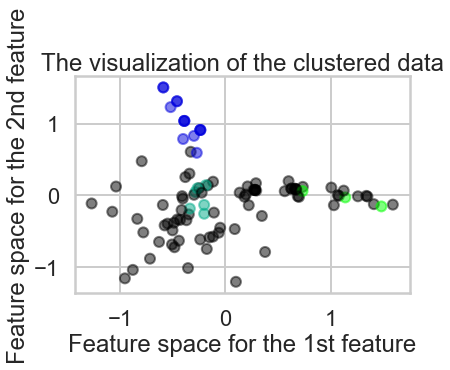

In [364]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(min_samples=3,eps=1)
dbscan_labels = dbscan.fit_predict(X)

# Create a scatter plot of the two principal components 
colors = cm.nipy_spectral(dbscan_labels.astype(float) / 5)
plt.scatter(customers_df.x, customers_df.y, marker='o', s=100, alpha=0.5, c=colors)
plt.title("The visualization of the clustered data")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

Based on above plots, agglomerative clustering performs the best at identifying the clusters that closely matched our groups. The other algorithms were unable to identify the distinct groups within the data.¶